# HMC

1175
372
4812


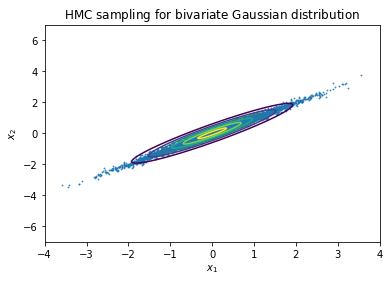

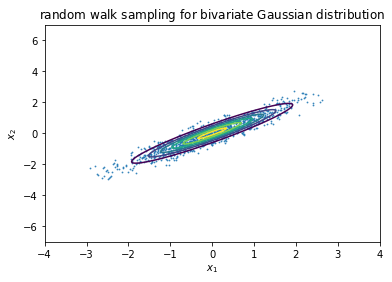

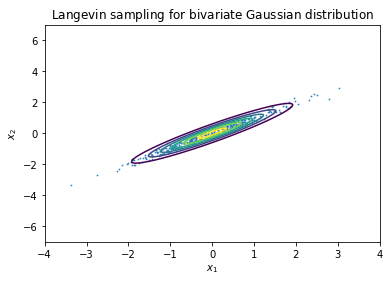

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jun  4 20:42:42 2018
"""

import numpy as np
import numpy.linalg as la
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

class HMC:    
    def __init__(self, x=np.random.rand(2), P=2000, N=20, temp=2.0, distribution=None, epsilon=0.1):
        self.T = temp
        self.X = np.empty((2,0))
        self.D = distribution
        self.N = N
        self.e = epsilon
        self.P = P
        self.dis = []
        self.x = x
        
    def leapfrog(self, p_t, x_t, g_t, e):
        p_half = p_t - e * .5 * g_t
        x_new = x_t + e * p_half

        for i in np.arange(0, self.N):
            g_new = self.D.grad(x_new)
            p_half = p_half - e * g_new
            x_new = x_new + e * p_half

        p_new = p_half - e * .5 * g_t
        return p_new, x_new
    
    def hmc(self):
        x = self.x[:,np.newaxis]
        p = np.random.randn(2)[:,np.newaxis]
        self.X = np.hstack((self.X, x))
        self.dis.append(self.D.dis(self.X))
        
        for i in np.arange(0, self.P):
            p = np.random.randn(2)[:,np.newaxis]
            e_old = self.energy(p, x)
            
            for i in np.arange(0, self.N):
                gradient = self.D.grad(x)
                p_n, x_n = self.leapfrog(p, x, gradient, self.e)
                e_new = self.energy(p_n, x_n)
            u = np.random.rand()
            r = self.acceptance_ratio(e_old, e_new)
            r = min(r, 1)
            if r >= u:
                self.X = np.hstack((self.X, x_n))
                x = x_n
                p = p_n
                self.dis.append(self.D.dis(self.X))
            
    def acceptance_ratio(self, e_old, e_new):
            return np.exp( (e_old - e_new) / self.T )
            
    def energy(self, p, x):
        return .5 * p.T.dot(p) + self.D.p(x)
    
    def output(self):
        return self.X
        
class BiGaussian:
    def __init__(self, mean=np.array([.0, .0]), cov=np.array([[1., .0], [.0, 1.]])):
        self.u = mean
        self.cov = cov
    
    def p(self, x):
        inv = np.linalg.inv(self.cov)
        x_prime = x - self.u[:, np.newaxis]
        return .5 * x_prime.T.dot(inv.dot(x_prime))
    
    def grad(self, x):
        inv = np.linalg.inv(self.cov)
        x_prime = x - self.u[:, np.newaxis]
        return inv.dot(x_prime)
    
    def dis(self, samples):
        return np.abs(np.linalg.norm(samples.dot(samples.T)/samples.shape[1] - self.cov))

def random_walk(x,h):
    return (x+np.sqrt(h)*np.random.multivariate_normal(np.zeros(2),np.identity(2)))

def langevin(x,inv,ss):
    return (x-.5*inv.dot(x)*ss+np.sqrt(ss)*
            np.random.multivariate_normal(np.zeros(2),np.identity(2)))
    
def purposal(x_prime,x,inv,ss):
    e = (x-x_prime-.5*inv.dot(x)*ss)[np.newaxis,:]
    return np.exp(-(e.dot(e.T))/(2*ss))

def p(x,mu,inv_cov,det):
    return np.exp(-.5*(x - mu).T.dot(inv_cov.dot((x - mu))))/det

def main():
    cov = np.array([[1.0, .95],[.95, 1.0]])
    det_cov = la.det(cov)
    det = np.sqrt( ((2*np.pi)**2) * det_cov )
    inv_cov = la.inv(cov)
    mu = np.zeros(2)

    #random walk sampling
    r_x = np.random.rand(2)
    rho = 1.0
    samples = np.array(r_x)
    r_cov = []
    r_dis = np.abs(np.linalg.norm((samples.T.dot(samples)/samples.shape[0]-cov)))
    r_cov.append(r_dis)
    
    #langevin sampling
    l_x = r_x
    delta = 1.0
    lan = np.array(l_x)
    l_cov = []
    l_dis = np.abs(np.linalg.norm((lan.T.dot(lan)/lan.shape[0]-cov)))
    l_cov.append(l_dis)
    
    for i in np.arange(0, 5000):
        px = p(r_x,mu,inv_cov,det)
        A = np.random.uniform(size=1)       
        x_prime = random_walk(r_x, rho)
        px_prime = p(x_prime,mu,inv_cov,det)
        if A <= (px_prime/px):
            samples = np.vstack((samples,x_prime))
            r_x = x_prime
            r_dis = np.abs(np.linalg.norm((samples.T.dot(samples)/samples.shape[0]-cov)))
            r_cov.append(r_dis)

        px = p(l_x,mu,inv_cov,det)
        A = np.random.uniform(size=1) 
        x_prime = langevin(l_x, inv_cov, delta)
        px_prime = p(x_prime, mu, inv_cov, det)
        qx_prime = purposal(x_prime, l_x, inv_cov, delta)
        qx = purposal(l_x, x_prime, inv_cov, delta)
        if A <= ((px_prime * qx)/(px * qx_prime)):
            lan = np.vstack((lan,x_prime))
            l_x = x_prime
            l_dis = np.abs(np.linalg.norm((lan.T.dot(lan)/lan.shape[0]-cov)))
            l_cov.append(l_dis)

    #hamiltonian monte carlo sampling

    d = BiGaussian(cov=cov)
    s = HMC(x=r_x, P=5000, temp=2.0, distribution=d)
    s.hmc()
    ham = s.output()

    print(samples.shape[0])
    print(lan.shape[0])
    print(ham.shape[1])

    delta = 0.025
    X = np.arange(-4, 4, delta)
    Y = np.arange(-7, 7, delta)
    X, Y = np.meshgrid(X, Y)
    Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0, .95)

    CS = plt.contour(X, Y, Z)
    plt.title(r'$\mathrm{HMC\ sampling\ for\ bivariate\ Gaussian\ distribution}$')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.scatter(ham[0], ham[1],alpha=0.8,s=0.7)
    plt.xlim(-4,4)
    plt.ylim(-7,7)
    plt.show()

    CS = plt.contour(X, Y, Z)
    plt.title(r'$\mathrm{random\ walk\ sampling\ for\ bivariate\ Gaussian\ distribution}$')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.scatter(samples.T[0],samples.T[1],alpha=0.8,s=0.7)
    plt.xlim(-4,4)
    plt.ylim(-7,7)
    plt.show()

    CS = plt.contour(X, Y, Z)
    plt.title(r'$\mathrm{Langevin\ sampling\ for\ bivariate\ Gaussian\ distribution}$')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.scatter(lan.T[0],lan.T[1],alpha=0.8,s=0.7)
    plt.xlim(-4,4)
    plt.ylim(-7,7)
    plt.show()

if __name__ == "__main__":
    main()